# Parallel Logistic Regression Classifier on Spark

Author: **Giorgio Polla**  
Date: **27/11/2019**  

Implementation of a Logistic Regression classifier on Spark, with Python.  
The algorithm is tested using cross-validation on the _Spam_ dataset available at https://web.stanford.edu/~hastie/ElemStatLearn/data.html.


### Libraries and constants

Import of the following libraries:  
* `time` to track the time performance of the implementation;  
* `pyspark` to utilize *Spark*;  
* `numpy` to easily operate with number arrays;  
* `matplotlib` to plot graphs;  
* `random` to provide the random functionalities used in the cross-validation dataset split;  

Moreover, some operative constants used in the following are defined, and finally the Spark context is intialised.

In [1]:
import time
import random
import pyspark
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

FILE_PATH = '../data/spam.txt'
OUT_PATH = '../out/'
IMG_FORMAT = 'png'
N_WORKERS = 8
EPSILON = 1e-10

In [2]:
if 'sc' in locals():
    print('Restarting Spark Context...')
    sc.stop()
else:
    print('Initialising Spark Context...')

sc = pyspark.SparkContext('local[' + str(N_WORKERS) + ']')
print('Done!')

Initialising Spark Context...
Done!


### File reading
The spam dataset is loaded as an RDD, using the `textFile()` function.  
The RDD is then manipulated in order to have each record as a tuple **(X, y)** , where:  
**X** is an array containing the features of the example (57 float numbers);  
**y** is an integer containing the label of the example (0 or 1).  

The result is then quickly tested.

In [3]:
def read_file(file_path, n_partitions=N_WORKERS):
    rdd = sc.textFile(file_path, n_partitions)
    
    rdd = rdd.map(
        lambda x: (
            np.array([float(el) for el in x.split()[:-1]]),
            int(x[-1])
        )
    )
    
    return rdd

In [4]:
rdd = read_file(FILE_PATH)
rdd.first()[0][56] # test -> 278.0

278.0

### Standardisation
Each row of the RDD is standardised; this is done by first obtaining the mean for each column, then obtaining the standard deviation for them, and finally applying the standardisation formula.  

The result is then again quickly tested.

In [5]:
def standardise(rdd):    
    n_rows = rdd.count()
    
    col_sum = rdd.map(
        lambda x:
            x[0]
    ).reduce(
        lambda x, y:
            x + y
    )
    mean = col_sum / n_rows
    
    variance = rdd.map(
        lambda x: np.square(x[0] - mean)
    ).reduce(
        lambda x, y:
            x + y
    )
    std_dev = np.sqrt(variance / n_rows)
    
    rdd = rdd.map(
        lambda x: (
            (x[0] - mean) /  std_dev,
            x[1]
        )
    )
    
    return rdd

In [6]:
rdd = standardise(rdd)
rdd.first()[0][56] # test -> -0.008724

-0.008724133882501232

### Training
The training phase follows the typical Logistic Regression fashion, with some adjustments to exploit the Spark parallelisation.  
It is worth noting that the notation is consistent, and in particular:  
* **rdd** is an RDD containing the records on which to train the model;
* **x** is a data point feature array (57 float numbers);  
* **y** is a data point label (integer, either 0 or 1);  
* **b** is the regression bias term (float number);  
* **w** is the regression weights array (57 float numbers);  
* **p** is the predicted class probability for of data point (float number between 0 and 1);

In the first section there are the support functions for the proper training phase.  
* `sigmoid()` simply represents the Sigmoid function;  
* `predict_probability()` calculates and returns the predicted class probability **y** for each record, exploting the `sigmoid()` function;  
* `cross_entropy()` is the Cross Entropy function, utilised to obtain the training error of the model;  
* `row_gradient()` calculates the partial elements needed in the following function to obtain the gradients and the loss;
* `gradient()` calculates the gradient for the bias term (**gradient_b**),  the gradient for the weights, in a single array (**gradient_w**), and the sum of the cross entropy error for each record.  

*Note: with the term 'gradient' we refer here to the previous step of the process to obtain the actual gradients (it is still nedeed to divide these results by the number of instances used to obtain them, but this will be done later in order to minimise the usage of the division operation); for simplicity's sake, it was still decided to call them in this way.*

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def predict_probability(x, b, w):
    z = np.dot(x, w) + b
    return sigmoid(z)


def cross_entropy(p, y):    
    if y == 1:
        cross_entropy_loss = -np.log(p + EPSILON)
    else:
        cross_entropy_loss = -np.log(1 - p + EPSILON)
    
    return cross_entropy_loss


def row_gradient(x, y, b, w):
    p = predict_probability(x, b, w)
    
    b_part = p - y
    g_part = b_part * x
    ce_loss_part = cross_entropy(p, y)
    
    return b_part, g_part, ce_loss_part


def gradient(rdd, b, w):
    gradient_b, gradient_w, error_loss = rdd.map(
        lambda x: 
            row_gradient(x[0], x[1], b, w)
    ).reduce(
        lambda x, y: (
            x[0] + y[0],
            x[1] + y[1],
            x[2] + y[2]
        )
    )
    
    return gradient_b, gradient_w, error_loss

The train function considerds the additional parameters:  
* **iterations**, the number of iterations to repeat in the training phase;
* **learning_rate**, the learing rate in the training phase;
* **lambda_reg**, the regularization parameter lambda, used to control the Ridge-like regularization adopted;
* **verbose**, controlling whether or not to stamp additional information.  

The training phase proceeds inside the main iteration loop by calculating each time the gradient for the bias **b** and the weights **w**, applying the gradient descent technique with appropriate regularization, and recording the total loss (**cross_entropy_loss** plus **regularisation_loss**).  
At the end of the training phase the function returns the trained bias and weights, as well as the array **loss_history** containing the records of the total loss during the whole process.

In [8]:
def train(rdd, iterations=10, learning_rate=10, 
          lambda_reg=0.1, verbose=True, plot_loss=False):
    if iterations < 1:
        raise ValueError('Invalid number of iterations: must be > 0!')
        
    start_time = time.time()
    
    n_rows = rdd.count()
    n_features = len(rdd.first()[0])
    alpha = learning_rate / n_rows
    b = 0
    w = np.zeros(n_features)
    loss_history = []
    
    if iterations > 4:
        verbose_fraction = np.floor(iterations / 5)
    else:
        verbose_fraction = 1
    
    for it in range(iterations):
        gradient_b, gradient_w, cross_entropy_loss = gradient(rdd, b, w)
        
        regularisation_loss = lambda_reg * np.sum(np.square(w)) / 2
        regularisation = lambda_reg * w
        
        b -= alpha * gradient_b
        w -= alpha * (gradient_w + regularisation)
        
        total_loss = (cross_entropy_loss + regularisation_loss) / n_rows
        loss_history.append(total_loss)
        
        if verbose and it % verbose_fraction == 0:
            print("It. %4d\t|\tLoss: %0.4f\t|\tTime: %0.2f s" %  
                  (it, total_loss, (time.time() - start_time)))
            
    total_time = time.time() - start_time
    if verbose:
        print("It. %4d\t|\tLoss: %0.4f\t|\tTime: %0.2f s" %
              (iterations, total_loss, total_time))
        print('\nTotal time: %0.2f s\nIters frequency: %0.2f Hz\n' % 
              (total_time, iterations / total_time))
        
    if plot_loss:
        plt.style.use('seaborn-darkgrid')
        plt.plot(loss_history, linewidth=2)
        plt.gcf().subplots_adjust(bottom=0.1)
        plt.title('Loss History')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()
        
    return b, w, total_time

### Performance Evaluation
The evaluation is entirely managed by the follwing two functions, following the usual parameter naming conventions.  
* `classify()` is a support function that returns wether a data point has been classified as a _True Positve_ (**tp**), a _True Negative_ (**tn**), a _False Negative_ (**fn**) or a _False Positve_ (**fp**);  
* `evaluate()` computes the traditional evaluation metric for classification, and in particular the **Accuracy**, **Precision**, **Recall**, **Specificity**, **F1-Score**, final **Cost Error**, area under the ROC curve (**AUC**) and precision-recall score (**P-R Score**), and returns them packed in a dictionary. If the parameter **plot** is positively flagged, the two plots of the ROC and precision-recall curves are displayed.

In [9]:
def classify(p, y, threshold=0.5):
    if (p >= threshold) == y:
        return 'tp' if y==1 else 'tn'
    else:
        return 'fn' if y==1 else 'fp'
    
    
def evaluate_row(x, y, b, w, threshold=0.5):
    p = predict_probability(x, b, w)
    
    c = classify(p, y, threshold=threshold)
    ce_part = cross_entropy(p, y)
    return c, ce_part
            
        
def evaluate(rdd, b, w, threshold=0.5):
    if threshold < 0  or threshold > 1:
        raise ValueError('Invalid threshold: must be between 0 and 1!')
    
    tmp_rdd = rdd.map(
        lambda x:
            evaluate_row(x[0], x[1], b, w, threshold=threshold)
    )
    
    final_loss = tmp_rdd.map(
        lambda x:
            x[1]
    ).sum()
    
    final_loss = final_loss / rdd.count()
    
    # Confusion Matrix c_m
    c_m = tmp_rdd.map(
        lambda x: (
            x[0],
            1
        )
    ).reduceByKey(
        lambda x, y:
            x + y
    )
    
    c_m = dict(c_m.collect())
    wanted_keys = ['tp', 'fp', 'tn', 'fn']
    
    if len(c_m.keys()) < 4:
        for wanted_key in wanted_keys:
            if wanted_key not in c_m.keys():
                c_m[wanted_key] = 0
                
    results = {}
    
    results['Confusion Matrix'] = c_m
    
    results['Accuracy'] = (c_m['tp'] + c_m['tn']) \
        / (c_m['tp'] + c_m['tn'] + c_m['fp'] + c_m['fn'])
    
    results['Precision'] = c_m['tp'] / (c_m['tp'] + c_m['fp'])
    
    results['Recall'] = c_m['tp'] / (c_m['tp'] + c_m['fn'])
    
    results['Specificity'] = c_m['tn'] / (c_m['tn'] + c_m['fp'])
    
    results['F1-Score'] = 2 * results['Precision'] * results['Recall'] \
        / (results['Precision'] + results['Recall'])
    
    results['Cost Error'] = final_loss
    
    return results

The following function calculates and displays (and, in case, saves to file) the ROC and the Precision-Recall curves. The evaluation is obtained by testing the trained model using the `evaluate()` function with different a total of values of **threshold**; the **points** parameter defines how many points to calculate in this evaluation.  

Note: the function can be significantly optimised, but since it is never recursively called it has been left this way, for now.

In [10]:
def calc_curves(rdd, b, w, points=10, save=False):
    # Precision array
    prec = []
    # True Positive Rate array
    tpr = []
    # False Positive Rate array
    fpr = []
    
    threshold_list = np.array(range(points + 1)) / points
    print('\nCalculating ROC and PR curves...')
    print('Number of points: %d' % points)
    
    for th in threshold_list:
        ev_tmp = evaluate(rdd, b, w, threshold=th)
        
        prec.append(ev_tmp['Precision'])
        tpr.append(ev_tmp['Recall'])
        fpr.append(1 - ev_tmp['Specificity'])
    
    # Plot ROC curve
    plt.style.use('seaborn-darkgrid')
    plt.plot(fpr, tpr, color='darkorange', linewidth=2,
             label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle = '--')
    plt.gcf().subplots_adjust(bottom=0.1)
    plt.legend(loc='lower right')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if save:
        plt.savefig(OUT_PATH + 'ROC_curve.' + IMG_FORMAT)        
    plt.figure()
    plt.plot()
    
    # Plot PR curve
    plt.style.use('seaborn-darkgrid')
    plt.plot(tpr, prec, color='darkblue', linewidth=2,
             label='PR curve')
    plt.gcf().subplots_adjust(bottom=0.1)
    plt.legend(loc='lower left')
    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    if save:
        plt.savefig(OUT_PATH + 'PR_curve.' + IMG_FORMAT)
    plt.plot()

### Cross-Validation
The traditional cross-validation technique is here implemented, with some tweakings to exploit the Spark parallelisation.  
* `transform_c_v()` transforms the RDD to allow the cross-validation split: each record is randomly assigned to one fold (which range depends on the **folds** number chosen) by adding a label assigned by the `randrange()` functions;  
* `get_block_data()` takes the original train RDD and splits it in **rdd_train** and **rdd_test** according to the labels of each element and the training fold extracted **fold_train**;

In [11]:
def transform_cv(rdd, folds):
    random.seed()
    rdd_cv = rdd.map(
        lambda x: (
            x[0],
            x[1],
            randrange(folds)
        )
    )
    return rdd_cv


def get_block_data(rdd, fold_train):
    rdd_train = rdd.filter(
        lambda x:
            x[2] != fold_train
    ).map(
        lambda x: (
            x[0],
            x[1]
        )
    )
    
    rdd_test = rdd.filter(
        lambda x:
            x[2] == fold_train
    ).map(
        lambda x: (
            x[0],
            x[1]
        )
    )
    return rdd_train, rdd_test

The proper cross-validation process is here executed: given an RDD and a number of folds **folds** in which to split the dataset (and the usual `train()` parameters, to pass to that function when called), it iterates the training and testing phases selecting each time the proper **rdd_test** and **rdd_train** split, according to the appropriate training fold **fold** selected.  

The accuracy of the trained model (obtained using the previously seen evaluating functions) is recorded for each fold iteration and then finally averaged in **average_accuracy**.  
The implementation also provides additional information about the time elapsed and the fold or training iteration frequency in the computation: these information can be displayed or not by acting on the **verbose** and **verbose_train** flags (respectively regarding information about the cross-validation process and the specific training iterations).

It.    0	|	Loss: 0.6931	|	Time: 0.49 s
It.   20	|	Loss: 0.2164	|	Time: 3.72 s
It.   40	|	Loss: 0.2116	|	Time: 6.48 s
It.   60	|	Loss: 0.2094	|	Time: 8.93 s
It.   80	|	Loss: 0.2082	|	Time: 11.43 s
It.  100	|	Loss: 0.2073	|	Time: 13.58 s

Total time: 13.58 s
Iters frequency: 7.37 Hz



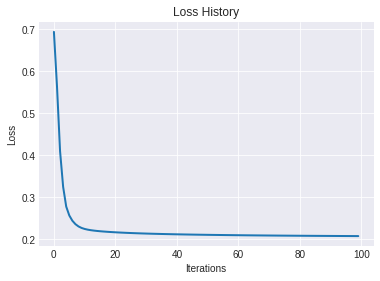

{'Confusion Matrix': {'tp': 1610, 'fp': 125, 'tn': 2663, 'fn': 203}, 'Accuracy': 0.9287111497500543, 'Precision': 0.9279538904899135, 'Recall': 0.888030888030888, 'Specificity': 0.9551649928263989, 'F1-Score': 0.9075535512965051, 'Cost Error': 0.207270440567011}

Calculating ROC and PR curves...
Number of points: 10


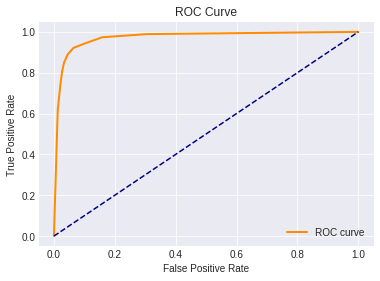

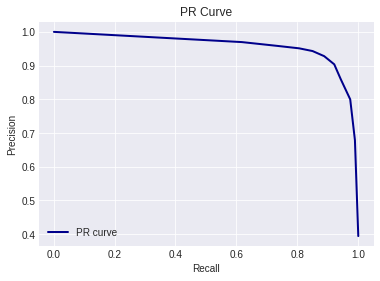

In [12]:
b, w, _ = train(rdd,
                iterations=100,
                learning_rate=10,
                lambda_reg=0.01,
                plot_loss=True
               )

print(evaluate(rdd, b, w, threshold=0.5))

calc_curves(rdd, b, w, points=10)

In [13]:
def cross_validation(rdd, folds=10, iterations=20, learning_rate=10, 
                     lambda_reg=0.1, threshold=0.5,
                     verbose=True, verbose_train=False):
    if folds < 2:
        raise ValueError('Invalid number of folds: must be > 1!')
        
    start_time = time.time()
        
    total_accuracy = 0
    rdd_cv = transform_cv(rdd, folds)

    for fold in range(folds):
        rdd_train, rdd_test = get_block_data(rdd_cv, fold)
        
        if verbose:
            tot_train = rdd_train.count()
            tot_test = rdd_test.count()
            perc_test = tot_test / (tot_test + tot_train) * 100
            print('Fold %2d of %2d\t|\t%4d test - %0.1f%%' % 
                  (fold + 1, folds, tot_test, perc_test), end='')
        
        b, w, _ = train(
            rdd_train,
            iterations=iterations,
            lambda_reg=lambda_reg,
            verbose=verbose_train
        )
        
        results = evaluate(rdd_test, b, w, threshold=threshold)
        accuracy = results['Accuracy']
        total_accuracy += accuracy
        if verbose:
            print('\t|\tAccuracy: %0.4f' % accuracy)

    average_accuracy = total_accuracy / folds
    total_time = time.time() - start_time
    if verbose:
        print('\nIters: %d' % 
              (iterations))
        print('Total time: %0.2f s\t|\tAverage accuracy: %0.4f' % 
              (total_time, average_accuracy))
        print('Fold frequency: %0.2f Hz' % (folds / total_time))    
        print('Iters frequency: %0.2f Hz' % (folds * iterations / total_time))
          
    return average_accuracy, total_time

In [14]:
avg_acc, tot_time = cross_validation(rdd, folds=5, iterations=20, 
                 learning_rate=10, lambda_reg=0.01, threshold=0.4,
                 verbose_train=False)

Fold  1 of  5	|	 952 test - 20.7%	|	Accuracy: 0.9055
Fold  2 of  5	|	 937 test - 20.4%	|	Accuracy: 0.9264
Fold  3 of  5	|	 942 test - 20.5%	|	Accuracy: 0.9172
Fold  4 of  5	|	 893 test - 19.4%	|	Accuracy: 0.9328
Fold  5 of  5	|	 877 test - 19.1%	|	Accuracy: 0.9350

Iters: 20
Total time: 15.70 s	|	Average accuracy: 0.9234
Fold frequency: 0.32 Hz
Iters frequency: 6.37 Hz


### Performance and Speed Up Curves
The main code below re-runs multiple times the training or the cross-validatio process, recording the time required with a different number of workers assigned, while maintaining a total of 8 partitions in the **rdd**.

In [15]:
worker_list = range(1, N_WORKERS + 1)
time_list = []

n_folds = 2
iterations = 120
boost_size = 1

exec_train = True

print('Evaluating %s\t\t|\tIters: %d\t|\t Boost: %dx' % 
      (('train' if exec_train else 'cross-val'), iterations, boost_size))
for workers in worker_list:
    if 'sc' in locals():
        sc.stop()
    sc = pyspark.SparkContext('local[' + str(workers) + ']')
    print('Starting with %d worker(s)' % workers, end ='')

    rdd = read_file(FILE_PATH)
    rdd = rdd.sample(True, boost_size) # eh...
    rdd = standardise(rdd)
    
    if exec_train:
        _, _, tmp_time = train(
            rdd,
            iterations=iterations,
            verbose=False
        )
    else:
        _, tmp_time = cross_validation(
            rdd,
            folds=n_folds, 
            iterations=iterations,
            verbose=False,
            verbose_train=False
        )
    
    time_list.append(tmp_time)
    print('\t|\tFinished in %0.2f s' % tmp_time)
print('Ended.')

Evaluating train		|	Iters: 120	|	 Boost: 1x
Starting with 1 worker(s)	|	Finished in 23.81 s
Starting with 2 worker(s)	|	Finished in 17.22 s
Starting with 3 worker(s)	|	Finished in 14.13 s
Starting with 4 worker(s)	|	Finished in 15.35 s
Starting with 5 worker(s)	|	Finished in 13.76 s
Starting with 6 worker(s)	|	Finished in 13.79 s
Starting with 7 worker(s)	|	Finished in 13.50 s
Starting with 8 worker(s)	|	Finished in 13.92 s
Ended.


This functions plots and eventually saves the performance curve, given the array of times required previously obtained. The parameter **interpolate** allows to manage the line interpolation.  

The function is then executed.

In [16]:
def performance_curve(time_array, n_init, save=False):
    t = np.array(time_array.copy())
    x_axis = [x for x in range(1, N_WORKERS + 1)]

    plt.style.use('seaborn-darkgrid')
    plt.plot(x_axis, t, linewidth=2)
    plt.gcf().subplots_adjust(bottom=0.1)
    plt.title('Performance Curve')
    plt.xlabel('Workers')
    plt.ylabel('Time (s)')
    
    if save:
        name = 'performance_curve.'
        plt.savefig(OUT_PATH + str(iterations)  + 'it__' + name + IMG_FORMAT)
    plt.show()

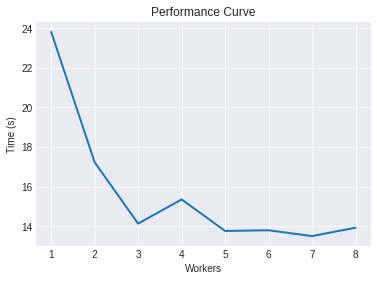

In [17]:
performance_curve(time_list, 
                  n_folds
                 )

This functions plots and eventually saves the speed up curve, given the array of times required previously obtained. The parameter **interpolate** allows to manage the line interpolation.

The function in then run.

In [18]:
def speed_up_curve(time_array, n_init, save=False):
    t = [time_array[0]/x for x in time_array]
    x_axis = [x for x in range(1, N_WORKERS + 1)]

    plt.style.use('seaborn-darkgrid')
    plt.plot(x_axis, t, linewidth=2)
    plt.gcf().subplots_adjust(bottom=0.1)
    plt.title('Speed Up Curve')
    plt.xlabel('Workers')
    plt.ylabel('Time ratio')
    
    if save:
        name = 'speed_up_curve-'
        plt.savefig(OUT_PATH + str(iterations)  + 'it__' + name + IMG_FORMAT)
    plt.show()

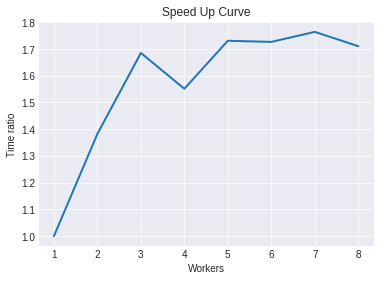

In [19]:
speed_up_curve(time_list, 
               n_folds
              )